In [2]:
%%capture
%run 02_FeatEng.ipynb

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from  sklearn.metrics import mean_squared_error  as skl_mse

In [4]:
import mle.tsa as mle_tsa

Importing plotly failed. Interactive plots will not work.


In [5]:
OUTPATH = 'data/out/'
OUTFILE = 'cons_gna95_sarimax.xlsx'

# Split Data

In [6]:
endog_GNA95_train = (data_train['cons_GNA95']/1e3).copy()
exog_GNA95_train = data_train[['price_GNA95_seas_adj_pct_change1_lag1']].copy()

In [7]:
endog_GNA95_test = (data_test['cons_GNA95']/1e3).copy()
exog_GNA95_test = data_test[['price_GNA95_seas_adj_pct_change1_lag1']].copy()

# Model Building

## Autosarima

In [8]:
# cast into kts
autosarima_gna95 = pm.auto_arima(y=endog_GNA95_train,
                                start_p=0, max_p=3,
                                start_q=0,max_q=3,
                                 trend='n', with_intercept=False,
                                d=1,
                                seasonal=True,
                                m=12, D=1,
                                start_P=0, max_P=3,
                                start_Q=0, max_Q=3,
                                information_criterion ='bic',
                              trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize bic
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1029.256, BIC=1032.044, Time=0.047 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=False]; AIC=983.959, BIC=992.321, Time=0.126 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=False]; AIC=958.138, BIC=966.500, Time=0.282 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=False]; AIC=985.575, BIC=991.150, Time=0.062 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=False]; AIC=956.147, BIC=967.297, Time=0.658 seconds
Near non-invertible roots for order (0, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=False]; AIC=955.776, BIC=966.926, Time=0.757 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=False]; AIC=974.656, BIC=983.018, Time=0.136 s

In [9]:
autosarima_gna95.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  133
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -472.094
Date:                              Sat, 27 Jun 2020   AIC                            952.189
Time:                                      17:50:11   BIC                            963.339
Sample:                                           0   HQIC                           956.717
                                              - 133                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7479      0.084     -8.858      0.000      -0.913      -0.582
ma.L2          0.2984      0.089      3.361      0.001       0.124       0.472
ma.S.L12      -0.7945      0.132     -6.013      0.000      -1.053      -0.536
sigma2       137.8914     21.593      6.386      0.000      95.570     180.213
===================================================================================
Ljung-Box (Q):                       94.19   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.00   Prob(JB):                         0.37
Heteroskedasticity (H):               0.50   Skew:                            -0.31
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
sarima_gna95_exo = SARIMAX(endog=endog_GNA95_train, exog=exog_GNA95_train,
                           order=(2,1,0), seasonal_order=(0,1,1,12), trend='n')
sarima_gna95_exo = sarima_gna95_exo.fit()
sarima_gna95_exo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           cons_GNA95   No. Observations:                  133
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -469.547
Date:                              Sat, 27 Jun 2020   AIC                            949.093
Time:                                      17:50:12   BIC                            963.031
Sample:                                  02-01-2008   HQIC                           954.753
                                       - 02-01-2019                                         
Covariance Type:                                opg                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
price_GNA95_seas_adj_pct_change1_lag1   -48.7530     26.416     -1.846      0.065    -100.528       3.022
ar.L1                                    -0.7220      0.086     -8.422      0.000      -0.890      -0.554
ar.L2                                    -0.3572      0.087     -4.083      0.000      -0.529      -0.186
ma.S.L12                                 -0.7574      0.119     -6.344      0.000      -0.991      -0.523
sigma2                                  134.0190     19.206      6.978      0.000      96.377     171.661
===================================================================================
Ljung-Box (Q):                       79.98   Jarque-Bera (JB):                 7.04
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               0.48   Skew:                            -0.55
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Selected Model Diagnostics

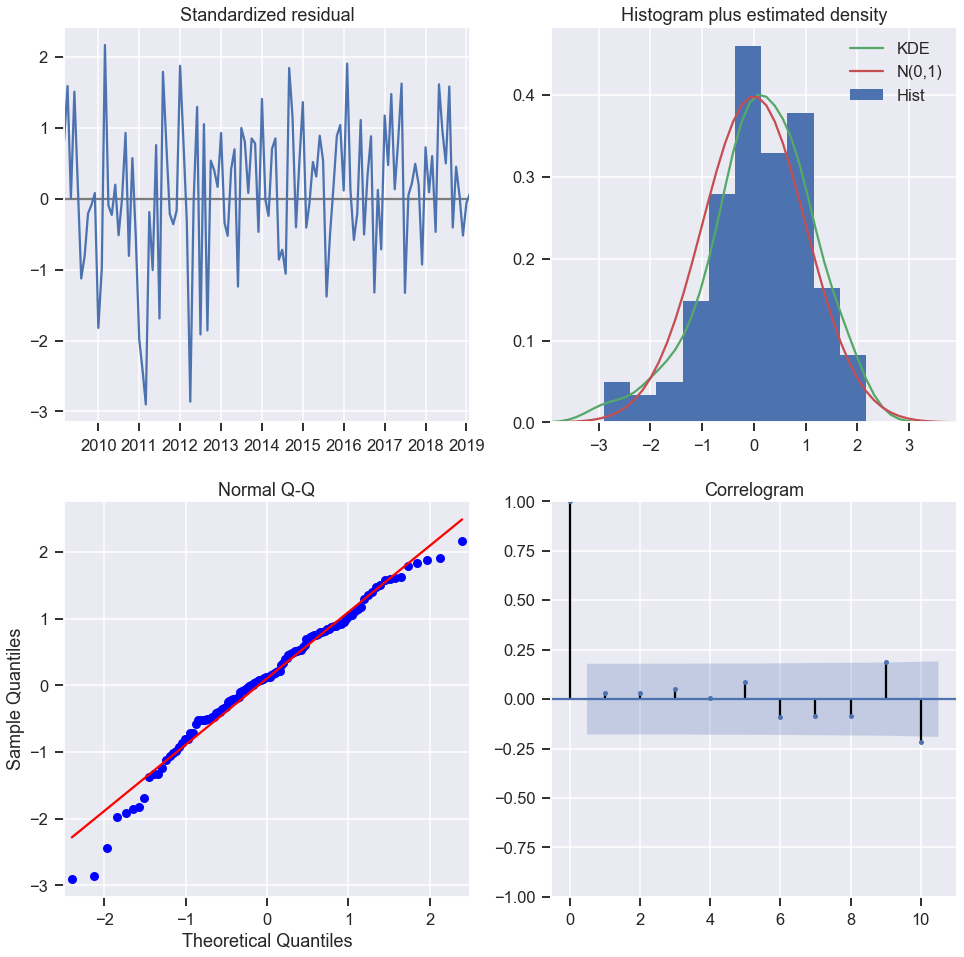

In [11]:
sarima_gna95_exo.plot_diagnostics(figsize=(16,16))
plt.show()

## Prediction

In [12]:
p_gna95_train = sarima_gna95_exo.predict().to_frame('p_cons_GNA95')[1:]*1e3
p_gna95_train[['lower p_cons_GNA95', 'upper p_cons_GNA95']] =  sarima_gna95_exo.get_prediction().conf_int()[13:]*1e3
p_gna95_train['cons_GNA95'] = endog_GNA95_train*1e3
p_gna95_train['model'] = 'sarimax'
p_gna95_train['split'] = 'train'
p_gna95_train.index = p_gna95_train.index.date

# Forecast

In [13]:
sarima_gna95_exo_upd, p_gna95_test = mle_tsa.exog_forecast(
    train_endog=endog_GNA95_train,
    train_exog=exog_GNA95_train,
    test_endog=endog_GNA95_test,
    test_exog=exog_GNA95_test,
    res=sarima_gna95_exo)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: 

In [14]:
p_gna95_test = p_gna95_test.rename(columns={'lower cons_GNA95': 'lower p_cons_GNA95', 'upper cons_GNA95': 'upper p_cons_GNA95'})
p_gna95_test['cons_GNA95'] = endog_GNA95_test
p_gna95_test= p_gna95_test*1e3

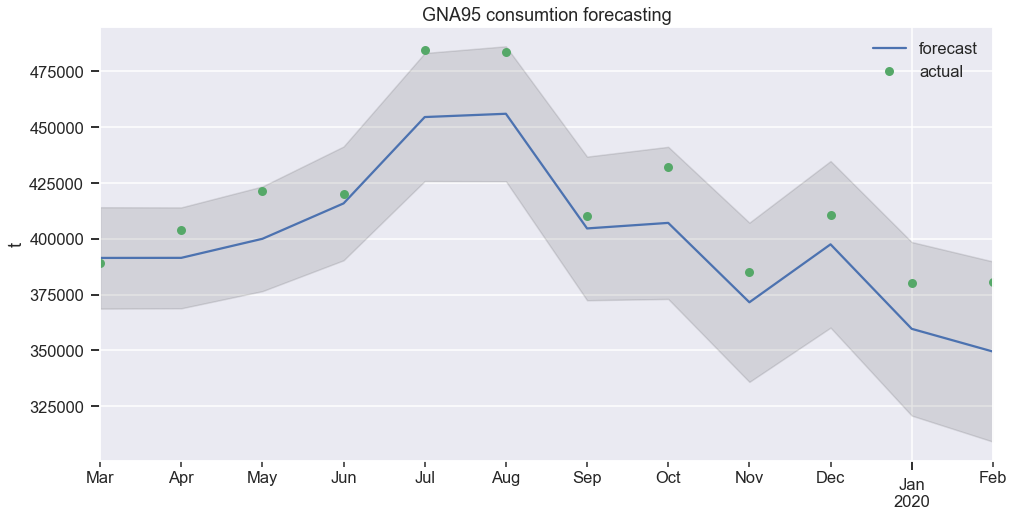

In [15]:
ax = p_gna95_test.plot(label='forecast', y = 'p_cons_GNA95')
p_gna95_test.plot(y='cons_GNA95', label='actual', style='o', ax=ax)
ax.fill_between(p_gna95_test.index, p_gna95_test['lower p_cons_GNA95'], p_gna95_test['upper p_cons_GNA95'], color='k', alpha=0.1)
plt.title("GNA95 consumtion forecasting")
plt.ylabel("t")
plt.legend()
plt.show()

# Model Assessment

In [16]:
p_gna95_test['split'] = 'test'
p_gna95_test['model'] = 'sarimax'
p_gna95_test.index = p_gna95_test.index.date

In [17]:
skl_mse(p_gna95_test['p_cons_GNA95']*1e3, data_test['cons_GNA95'])**0.5

400703490.15742284

In [18]:
mle_tsa.compute_ape(p_gna95_test['p_cons_GNA95'], data_test['cons_GNA95']).mean()

0.04325216157863313

In [19]:
select_cols = ['model', 'split', 'cons_GNA95', 'p_cons_GNA95', 'lower p_cons_GNA95', 'upper p_cons_GNA95']

pd.concat([p_gna95_train, p_gna95_test], axis=0)[select_cols].to_excel(OUTPATH + OUTFILE, index_label='Date')